## Imbalance dataset

In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

print(torch.__version__)

notebook_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)


2.2.2
/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction


### Import current imputed dataset

In [ ]:
# DATA_PATH = get_data.get_dataset_abspath()
# load_path = os.path.join(DATA_PATH, "imputed_sofa.parquet")
# imputed_df = pd.read_parquet(load_path)

# imputed_df.head(5)

In [2]:
from utils import get_data

DATA_PATH = get_data.get_dataset_abspath()
load_path = os.path.join(DATA_PATH, "Fully_imputed_dataset.parquet")
imputed_df = pd.read_parquet(load_path)


In [3]:
imputed_df.head(5)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,dataset,cluster_id
0,102.108491,91.419811,36.919203,128.165094,88.199717,67.007325,24.712264,29.6875,0.091837,22.811236,...,83.14,0,0.755119,0.244881,-0.03,1,0,1,A,0_9_4_3_X_X_X
1,97.000000,95.000000,36.919203,98.000000,75.330000,67.007325,19.000000,29.6875,0.091837,22.811236,...,83.14,0,0.755119,0.244881,-0.03,2,0,1,A,0_9_4_3_X_X_X
2,89.000000,99.000000,36.919203,122.000000,86.000000,67.007325,22.000000,29.6875,0.091837,22.811236,...,83.14,0,0.755119,0.244881,-0.03,3,0,1,A,0_9_4_3_X_X_X
3,90.000000,95.000000,36.919203,122.000000,88.665000,67.007325,30.000000,29.6875,24.000000,22.811236,...,83.14,0,0.755119,0.244881,-0.03,4,0,1,A,0_9_4_3_X_X_X
4,103.000000,88.500000,36.919203,122.000000,91.330000,67.007325,24.500000,29.6875,0.091837,22.811236,...,83.14,0,0.755119,0.244881,-0.03,5,0,1,A,0_9_4_3_X_X_X


In [4]:
unique_patients = imputed_df['patient_id'].nunique()
positive_patients = imputed_df.groupby('patient_id')['SepsisLabel'].max().sum()
percentage_positive = (positive_patients / unique_patients) * 100
print("Total patients:", unique_patients)
print("Percentage of true positive sepsis patients: {:.2f}%".format(percentage_positive))

Total patients: 40336
Percentage of true positive sepsis patients: 7.27%


In [6]:
groputed_by_patient = imputed_df.groupby('patient_id').head(1)

### Quick exploration

Label 0: 37404 (92.73%)
Label 1: 2932 (7.27%)


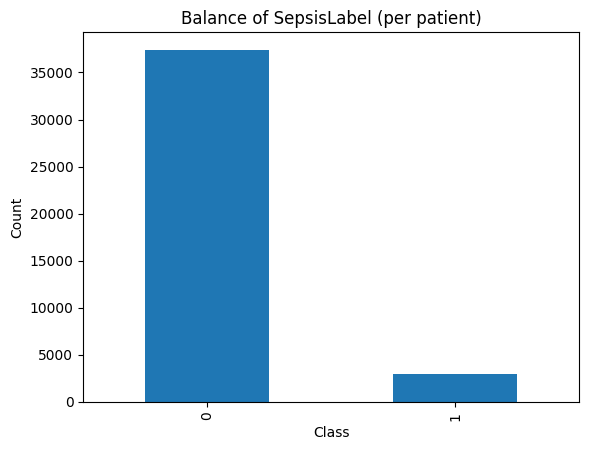

Patient-level balance statistics:
Total patients: 40336
Label 0: 37404 patients (92.73%)
Label 1: 2932 patients (7.27%)
Imbalance ratio (majority/minority): 12.76

Reflection:
Positive cases are only 7.27% of patients. This is very low for our sepsis challenge.
Consider applying resampling or cost-sensitive methods to create a richer dataset for training.


In [5]:
def balance_report(df):
    patient_df = df.groupby("patient_id")["SepsisLabel"].max().reset_index()
    counts = patient_df["SepsisLabel"].value_counts()
    total = counts.sum()
    for label, count in counts.items():
        print(f"Label {label}: {count} ({(count / total * 100):.2f}%)")
    
    counts.plot(kind="bar", title=f"Balance of SepsisLabel (per patient)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

def display_balance_statistics(df, plot=True):
    patient_df = df.groupby("patient_id")["SepsisLabel"].max().reset_index()
    counts = patient_df["SepsisLabel"].value_counts()
    total_patients = counts.sum()
    print("Patient-level balance statistics:")
    print("Total patients:", total_patients)
    for label, count in counts.items():
        perc = (count / total_patients) * 100
        print(f"Label {label}: {count} patients ({perc:.2f}%)")
    if len(counts) >= 2:
        imbalance_ratio = counts.max() / counts.min()
        print(f"Imbalance ratio (majority/minority): {imbalance_ratio:.2f}")
    else:
        print("Only one class present; check your data!")
    
    minority_percentage = counts.min() / total_patients * 100
    print("\nReflection:")
    if minority_percentage < 10:
        print(f"Positive cases are only {minority_percentage:.2f}% of patients. This is very low for our sepsis challenge.")
        print("Consider applying resampling or cost-sensitive methods to create a richer dataset for training.")
    else:
        print("The balance between classes seems acceptable.")


balance_report(imputed_df)
display_balance_statistics(imputed_df)

## Technique 1: balance dataset with oversample / undersample

In [8]:
from sklearn.utils import resample


def balance_over_under_sample(df, method="oversample", minority_ratio=0.5):
    """
    Balances the dataset at the patient level.
    
    Each patient's overall sepsis label is taken as the maximum value
    (if any record shows sepsis, the patient is marked as septic).
    
    We then either oversample the septic (minority) patients or undersample
    the non-septic (majority) patients to change the ratio.
    
    In the final dataset, each copy of a patient gets a unique ID so that
    oversampled patients appear as separate instances.
    """
    # Create a patient-level summary with one record per patient.
    patient_df = df.groupby("patient_id")["SepsisLabel"].max().reset_index()
    
    # Count patients in each group.
    counts = patient_df["SepsisLabel"].value_counts()
    majority_class = counts.idxmax()  # e.g., non-septic (0)
    minority_class = counts.idxmin()  # e.g., septic (1)
    
    # Split the patients into majority and minority groups.
    majority_patients = patient_df[patient_df["SepsisLabel"] == majority_class]
    minority_patients = patient_df[patient_df["SepsisLabel"] == minority_class]
    
    # Resample based on the chosen method.
    if method == "oversample":
        # Duplicate minority patients to reach desired ratio.
        # n_samples = int(len(majority_patients) * minority_ratio)
        n_desired_minority = int((minority_ratio * len(majority_patients)) / (1 - minority_ratio))
        minority_upsampled = resample(minority_patients, replace=True, 
                                      n_samples=n_desired_minority, random_state=42)
        balanced_patient_df = pd.concat([majority_patients, minority_upsampled])
    elif method == "undersample":
        # Remove some majority patients to reach desired ratio.
        # n_samples = int(len(minority_patients) / minority_ratio)
        n_desired_majority = int(((1 - minority_ratio) / minority_ratio) * len(minority_patients))
        majority_downsampled = resample(majority_patients, replace=False, 
                                        n_samples=n_desired_majority, random_state=42)
        balanced_patient_df = pd.concat([majority_downsampled, minority_patients])
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")
    
    # Rebuild the full dataset with patient records.
    # If a patient appears more than once due to resampling,
    # assign a new unique patient ID to each duplicate.
    final_dfs = []
    patient_occurrences = {}
    
    for pid in balanced_patient_df["patient_id"]:
        # Get all records for this patient.
        patient_records = df[df["patient_id"] == pid].copy()
        # Count how many times this patient has been added.
        if pid in patient_occurrences:
            patient_occurrences[pid] += 1
            # Create a new unique ID by appending a suffix.
            new_pid = f"{pid}_dup{patient_occurrences[pid]}"
            patient_records["patient_id"] = new_pid
        else:
            patient_occurrences[pid] = 0  # first occurrence, keep original ID
        final_dfs.append(patient_records)
    
    balanced_df = pd.concat(final_dfs, ignore_index=True)
    
    return balanced_df



### Oversample

Label 0: 37404 (50.00%)
Label 1: 37404 (50.00%)


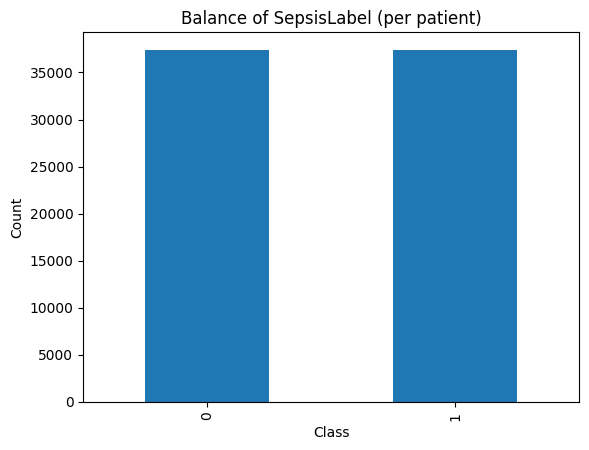

Patient-level balance statistics:
Total patients: 74808
Label 0: 37404 patients (50.00%)
Label 1: 37404 patients (50.00%)
Imbalance ratio (majority/minority): 1.00

Reflection:
The balance between classes seems acceptable.


In [9]:
balanced_df = balance_over_under_sample(imputed_df, method="oversample", minority_ratio=0.5)
balance_report(balanced_df)
display_balance_statistics(balanced_df)

### Undersample

Label 0: 5864 (66.67%)
Label 1: 2932 (33.33%)


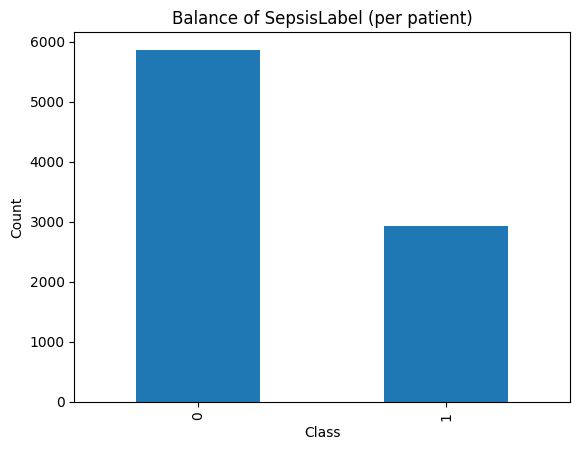

Patient-level balance statistics:
Total patients: 8796
Label 0: 5864 patients (66.67%)
Label 1: 2932 patients (33.33%)
Imbalance ratio (majority/minority): 2.00

Reflection:
The balance between classes seems acceptable.


In [11]:
under_balanced_df = balance_over_under_sample(imputed_df, method="undersample", minority_ratio=0.5)
balance_report(under_balanced_df)
display_balance_statistics(under_balanced_df)

## Technique 2: Waight random sampler
https://www.kaggle.com/code/syzygyfy/addressing-the-class-imbalance-in-pytorch